In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product

### Read in the data

In [2]:
device_activations = pd.read_csv('data/device_activations.csv')

In [3]:
device_activations.head()

,time,device,device_activated
0,2016-07-01 04:23:32,device_6,1
1,2016-07-01 06:52:57,device_2,1
2,2016-07-01 06:53:00,device_2,1
3,2016-07-01 06:56:41,device_2,1
4,2016-07-01 07:00:01,device_6,1


### Inspect & Clean the data

In [4]:
device_activations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9045 entries, 0 to 9044
Data columns (total 3 columns):
time                9045 non-null object
device              9045 non-null object
device_activated    9045 non-null int64
dtypes: int64(1), object(2)
memory usage: 212.1+ KB


In [5]:
device_activations.time = pd.to_datetime(device_activations.time)

In [6]:
device_activations.device_activated.value_counts()

1    9045
Name: device_activated, dtype: int64

In [7]:
device_activations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9045 entries, 0 to 9044
Data columns (total 3 columns):
time                9045 non-null datetime64[ns]
device              9045 non-null object
device_activated    9045 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 212.1+ KB


* Create a new column corresponding to the hour since start of data

In [8]:
earliest_date = min(device_activations.time).date()

device_activations['date'] = device_activations['time'].dt.date
device_activations['hour_of_day'] = device_activations['time'].dt.hour
device_activations['hour_of_week'] = device_activations['time'].dt.dayofweek * 24 + device_activations['hour_of_day']
device_activations['hour_slot'] = (device_activations['date'] - earliest_date).dt.days * 24 + device_activations['hour_of_day']

In [9]:
device_activations.head()

,time,device,device_activated,date,hour_of_day,hour_of_week,hour_slot
0,2016-07-01 04:23:32,device_6,1,2016-07-01,4,100,4
1,2016-07-01 06:52:57,device_2,1,2016-07-01,6,102,6
2,2016-07-01 06:53:00,device_2,1,2016-07-01,6,102,6
3,2016-07-01 06:56:41,device_2,1,2016-07-01,6,102,6
4,2016-07-01 07:00:01,device_6,1,2016-07-01,7,103,7


In [10]:
# Create a blank dataset for every hour and device
all_devices = list(device_activations.device.unique())
n_hours = ((max(device_activations.time) - min(device_activations.time)).days+1)*24
hour_slot = list(range(n_hours))

blank_df = pd.DataFrame(list(product(all_devices, hour_slot)), columns=['device', 'hour_slot'])
blank_df['hour_of_day'] = blank_df.hour_slot % 24
blank_df['hour_of_week'] = blank_df.hour_slot % (7*24)
blank_df['day_num'] = np.floor(blank_df.hour_slot/24).astype(int)
blank_df['week_num'] = np.floor(blank_df.hour_slot/(24*7)).astype(int)
blank_df['day_of_week'] = np.floor(blank_df.hour_of_week/7).astype(int)
blank_df.head()

,device,hour_slot,hour_of_day,hour_of_week,day_num,week_num,day_of_week
0,device_6,0,0,0,0,0,0
1,device_6,1,1,1,0,0,0
2,device_6,2,2,2,0,0,0
3,device_6,3,3,3,0,0,0
4,device_6,4,4,4,0,0,0


In [11]:
#Cleanup the activation data in order to join with the blank data
agg_dict = {
    'time': {
        'earliest_activation': min,
        'latest_activation': max
        },
    'device_activated': sum
}

grouped_df = device_activations.groupby(['device', 'hour_slot']).agg(agg_dict).reset_index()
grouped_df.columns = grouped_df.columns.droplevel(0)
grouped_df.columns = [
    'device',
    'hour_slot',
    'earliest_activation',
    'latest_activation',
    'total_activations'
]
grouped_df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,device,hour_slot,earliest_activation,latest_activation,total_activations
0,device_1,592,2016-07-25 16:09:37,2016-07-25 16:57:39,6
1,device_1,607,2016-07-26 07:31:08,2016-07-26 07:52:41,2
2,device_1,608,2016-07-26 08:02:51,2016-07-26 08:56:42,6
3,device_1,609,2016-07-26 09:15:25,2016-07-26 09:49:18,4
4,device_1,610,2016-07-26 10:01:39,2016-07-26 10:59:32,10


In [12]:
grouped_df.shape

(1967, 5)

In [13]:
#Join with the activation data and cleanup
df = pd.merge(blank_df, grouped_df, how='left')
df['is_active'] = (df.total_activations.isna() == False).astype(int)
df.head()

,device,hour_slot,hour_of_day,hour_of_week,day_num,week_num,day_of_week,earliest_activation,latest_activation,total_activations,is_active
0,device_6,0,0,0,0,0,0,NaT,NaT,NaN,0
1,device_6,1,1,1,0,0,0,NaT,NaT,NaN,0
2,device_6,2,2,2,0,0,0,NaT,NaT,NaN,0
3,device_6,3,3,3,0,0,0,NaT,NaT,NaN,0
4,device_6,4,4,4,0,0,0,2016-07-01 04:23:32,2016-07-01 04:23:32,1.0,1


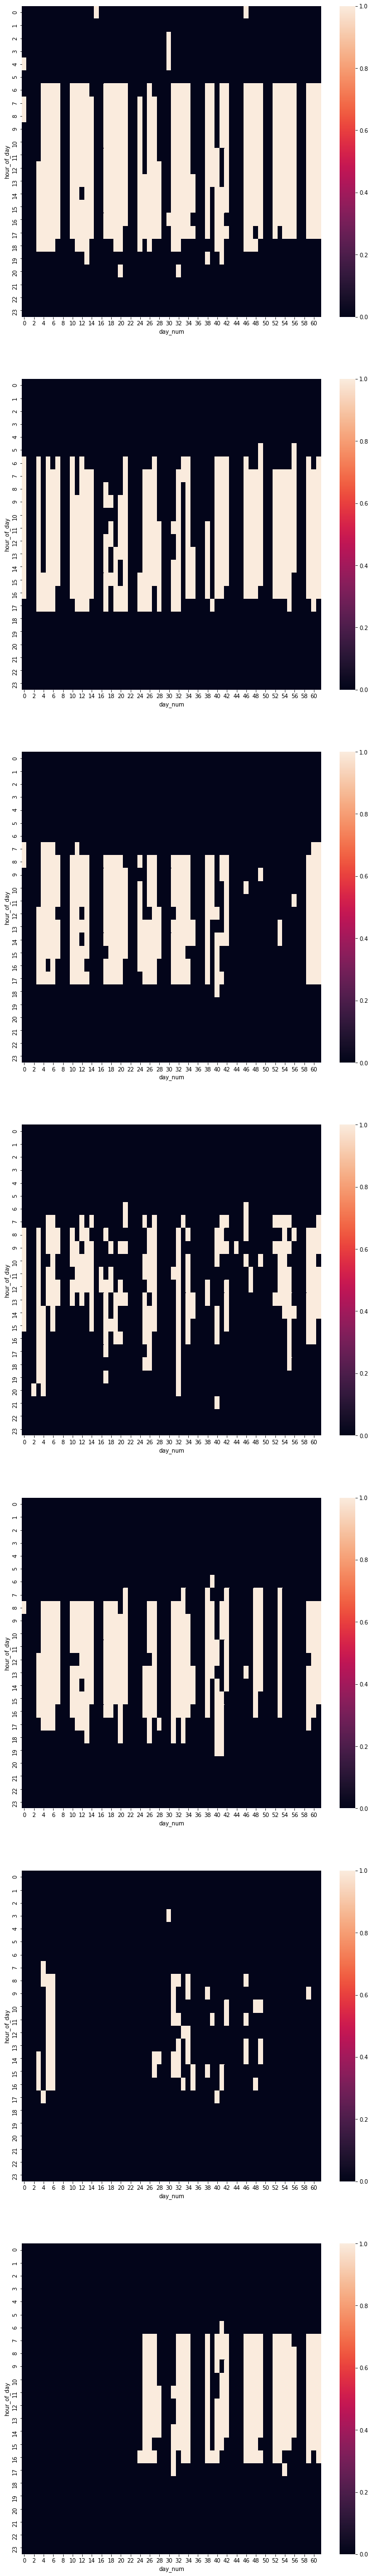

In [14]:
n_devices = len(all_devices)
fig, axs = plt.subplots(nrows = n_devices, figsize = (12, 12*n_devices))

for i, device in zip(range(n_devices), all_devices):
    sns.heatmap(
        df[df.device == device].pivot("hour_of_day", "day_num", "is_active"), 
        ax=axs[i]
    )

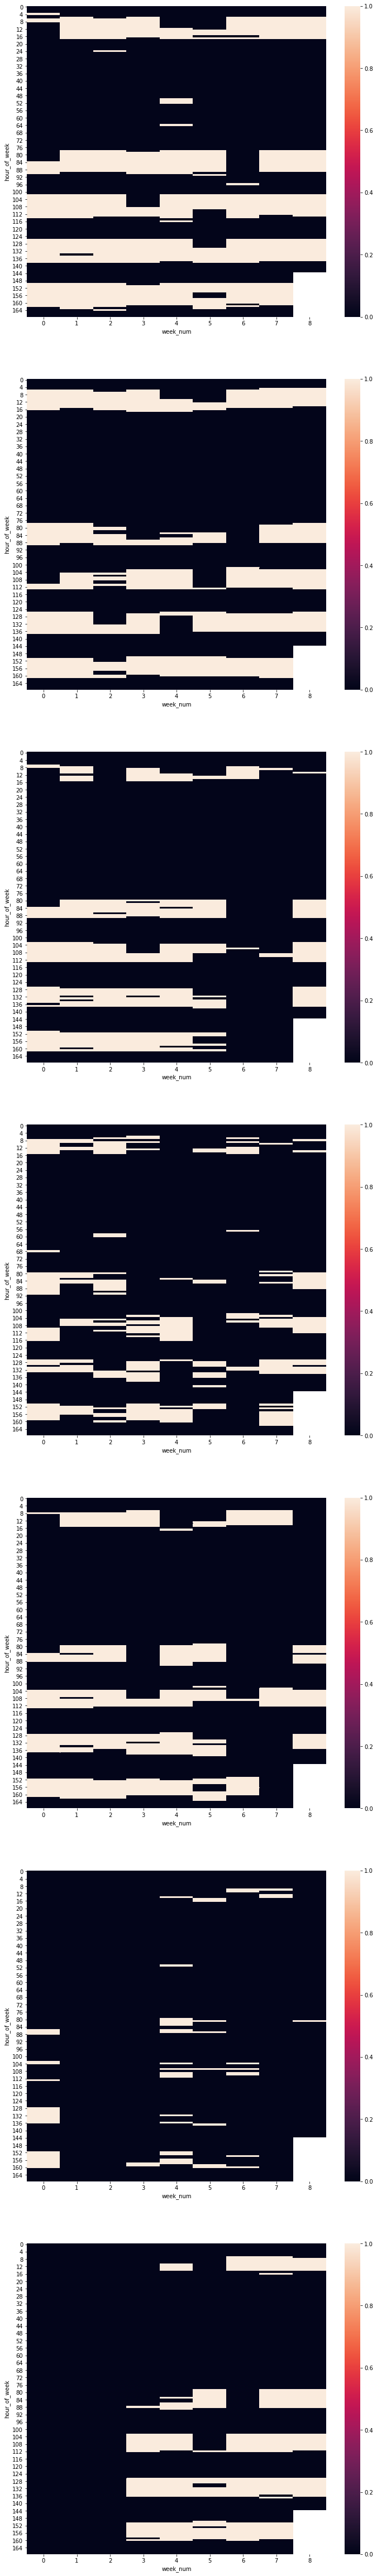

In [15]:
n_devices = len(all_devices)
fig, axs = plt.subplots(nrows = n_devices, figsize = (12, 12*n_devices))

for i, device in zip(range(n_devices), all_devices):
    sns.heatmap(
        df[df.device == device].pivot("hour_of_week", "week_num", "is_active"), 
        ax=axs[i]
    )

In [16]:
df.head()

,device,hour_slot,hour_of_day,hour_of_week,day_num,week_num,day_of_week,earliest_activation,latest_activation,total_activations,is_active
0,device_6,0,0,0,0,0,0,NaT,NaT,NaN,0
1,device_6,1,1,1,0,0,0,NaT,NaT,NaN,0
2,device_6,2,2,2,0,0,0,NaT,NaT,NaN,0
3,device_6,3,3,3,0,0,0,NaT,NaT,NaN,0
4,device_6,4,4,4,0,0,0,2016-07-01 04:23:32,2016-07-01 04:23:32,1.0,1


# Create the training data

Was the device active this time last week?

In [17]:
#Select only the required columns
active_last_week_df = df[['device', 'hour_slot', 'hour_of_week', 'week_num']]

#Create a lag_week_num variable to join on
active_last_week_df['lag_week_num'] = active_last_week_df['week_num'] - 1

#Join with last weeks data
active_last_week_df = pd.merge(
    active_last_week_df,
    df[['device', 'hour_of_week', 'week_num', 'is_active']],
    how = 'left',
    left_on = ['device', 'hour_of_week', 'lag_week_num'],
    right_on = ['device', 'hour_of_week', 'week_num']
)

#Clean up
active_last_week_df = active_last_week_df[['device', 'hour_slot', 'is_active']]
active_last_week_df.columns = ['device', 'hour_slot', 'is_active_last_week']
active_last_week_df.sample(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,device,hour_slot,is_active_last_week
7181,device_5,1229,0.0
943,device_6,943,1.0
4416,device_4,1440,0.0
7221,device_5,1269,0.0
9345,device_1,417,0.0


Was the device active this time yesterday?

In [18]:
#Select only the required columns
active_yesterday_df = df[['device', 'hour_slot', 'hour_of_day', 'day_num']]

#Create a lag_day_num variable to join on
active_yesterday_df['lag_day_num'] = active_yesterday_df['day_num'] - 1

#Join with last weeks data
active_yesterday_df = pd.merge(
    active_yesterday_df,
    df[['device', 'hour_of_day', 'day_num', 'is_active']],
    how = 'left',
    left_on = ['device', 'hour_of_day', 'lag_day_num'],
    right_on = ['device', 'hour_of_day', 'day_num']
)

#Clean up
active_yesterday_df = active_yesterday_df[['device', 'hour_slot', 'is_active']]
active_yesterday_df.columns = ['device', 'hour_slot', 'is_active_yesterday']
active_yesterday_df.sample(5)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,device,hour_slot,is_active_yesterday
1679,device_2,191,0.0
2446,device_2,958,0.0
5074,device_3,610,0.0
8803,device_7,1363,0.0
4220,device_4,1244,0.0


* What's the average activation rate for this room at this time of the day

(Potentially could try normalize within week or something like that?)

In [19]:
# Sort values by hour_slot
df.sort_values(by='hour_slot', inplace=True, ascending=True)

#Select only the required columns
hour_of_day_activation_rate_df = df[['device', 'hour_slot', 'hour_of_day', 'day_num', 'is_active']]

#Create a custom aggregation function to calculate the mean before this value
def mean_pre_now(x):
    return np.mean(x[:-1])

agg_dict = {
    'is_active': mean_pre_now,
    'hour_slot': max
}

# Group by device, hour_of_day
hour_of_day_activation_rate_df = hour_of_day_activation_rate_df.\
                                groupby(['device', 'hour_of_day']).\
                                expanding().\
                                agg(agg_dict)[['is_active', 'hour_slot']].\
                                reset_index(drop=False)

hour_of_day_activation_rate_df = hour_of_day_activation_rate_df[['device', 'hour_slot', 'is_active']]
hour_of_day_activation_rate_df.columns = ['device', 'hour_slot', 'daily_activation_rate']
hour_of_day_activation_rate_df.sample(10)

,device,hour_slot,daily_activation_rate
5401,device_4,183.0,0.571429
1234,device_1,1363.0,0.000000
8400,device_6,735.0,0.666667
9679,device_7,180.0,0.285714
3501,device_3,704.0,0.379310
6885,device_5,87.0,0.000000
2087,device_2,993.0,0.487805
9543,device_7,1377.0,0.087719
547,device_1,1232.0,0.274510
8533,device_6,953.0,0.641026


* What's the average activation rate for this room at this time of the week


In [20]:
# Sort values by hour_slot
df.sort_values(by='hour_slot', inplace=True, ascending=True)

#Select only the required columns
weekly_activation_rate_df = df[['device', 'hour_slot', 'hour_of_week', 'week_num', 'is_active']]

#Create a custom aggregation function to calculate the mean before this value
def mean_pre_now(x):
    return np.mean(x[:-1])

agg_dict = {
    'is_active': mean_pre_now,
    'hour_slot': max
}

# Group by device, hour_of_day
weekly_activation_rate_df = weekly_activation_rate_df.\
                                groupby(['device', 'hour_of_week']).\
                                expanding().\
                                agg(agg_dict)[['is_active', 'hour_slot']].\
                                reset_index(drop=False)

weekly_activation_rate_df = weekly_activation_rate_df[['device', 'hour_slot', 'is_active']]
weekly_activation_rate_df.columns = ['device', 'hour_slot', 'weekly_activation_rate']
weekly_activation_rate_df.sample(10)

,device,hour_slot,weekly_activation_rate
3140,device_3,354.0,0.000000
3985,device_3,280.0,1.000000
7680,device_6,1034.0,0.000000
7336,device_5,155.0,NaN
4805,device_4,1381.0,0.000000
9364,device_7,720.0,0.000000
6286,device_5,205.0,0.000000
888,device_1,1106.0,0.000000
3775,device_3,1264.0,0.285714
1711,device_2,1200.0,0.000000


* What's the average activation rate for this room for the last week

In [21]:
#Get average daily activations for each device
weekly_device_activation_rate_df = df.groupby(['device', 'day_num'])\
                                .agg(np.mean)['is_active']\
                                .reset_index(drop=False)
weekly_device_activation_rate_df.columns = ['device', 'day_num', 'activation_rate']

weekly_device_activation_rate_df.sort_values('day_num', ascending = True)
weekly_device_activation_rate_df['weeks_activation_rate'] = weekly_device_activation_rate_df\
                                                        .groupby('device')['activation_rate']\
                                                        .rolling(7).mean()\
                                                        .reset_index(drop=True)

#Add 1 to the day for joining with original df
weekly_device_activation_rate_df['lead_day_num'] = weekly_device_activation_rate_df['day_num'] + 1
            
weekly_device_activation_rate_df = pd.merge(
    df[['device', 'hour_slot', 'day_num']],
    weekly_device_activation_rate_df,
    how = 'left',
    left_on = ['device', 'day_num'],
    right_on = ['device', 'lead_day_num']
)

#Clean up
keep_cols = [
    'device',
    'hour_slot',
    'activation_rate',
    'weeks_activation_rate'
    ]
weekly_device_activation_rate_df = weekly_device_activation_rate_df[keep_cols]
weekly_device_activation_rate_df.columns = [
    'device',
    'hour_slot',
    'yesterdays_device_activation_rate',
    'last_weeks_device_activation_rate'
]

weekly_device_activation_rate_df.sample(10)

,device,hour_slot,yesterdays_device_activation_rate,last_weeks_device_activation_rate
843,device_6,120,0.541667,NaN
7652,device_4,1093,0.000000,0.190476
7834,device_7,1119,0.000000,0.035714
5823,device_3,831,0.041667,0.142857
6601,device_7,943,0.083333,0.095238
413,device_1,59,0.000000,NaN
2220,device_1,317,0.000000,0.000000
401,device_5,57,0.000000,NaN
4542,device_3,648,0.416667,0.154762
8092,device_5,1156,0.000000,0.101190


* What's the average activation rate for all rooms for the last week

In [22]:
#Get average daily activations for each device
weekly_all_device_activation_rate_df = df.groupby('day_num')\
                                .agg(np.mean)['is_active']\
                                .reset_index(drop=False)
weekly_all_device_activation_rate_df.columns = ['day_num', 'activation_rate']

weekly_all_device_activation_rate_df.sort_values('day_num', ascending = True)
weekly_all_device_activation_rate_df['weeks_activation_rate'] = weekly_all_device_activation_rate_df['activation_rate']\
                                                        .rolling(7).mean()\
                                                        .reset_index(drop=True)

#Add 1 to the day for joining with original df
weekly_all_device_activation_rate_df['lead_day_num'] = weekly_all_device_activation_rate_df['day_num'] + 1
            
weekly_all_device_activation_rate_df = pd.merge(
    df[['device', 'hour_slot', 'day_num']],
    weekly_all_device_activation_rate_df,
    how = 'left',
    left_on = 'day_num',
    right_on = 'lead_day_num'
)

#Clean up
keep_cols = [
    'device',
    'hour_slot',
    'activation_rate',
    'weeks_activation_rate'
    ]
weekly_all_device_activation_rate_df = weekly_all_device_activation_rate_df[keep_cols]
weekly_all_device_activation_rate_df.columns = [
    'device',
    'hour_slot',
    'yesterdays_all_device_activation_rate',
    'last_weeks_all_device_activation_rate'
]

weekly_all_device_activation_rate_df.sample(10)

,device,hour_slot,yesterdays_all_device_activation_rate,last_weeks_all_device_activation_rate
8778,device_3,1254,0.000000,0.143707
3808,device_5,544,0.255952,0.183673
9786,device_5,1398,0.000000,0.168367
6348,device_2,906,0.000000,0.216837
8021,device_3,1145,0.267857,0.165816
7619,device_5,1088,0.005952,0.192177
4004,device_2,572,0.000000,0.182823
7256,device_3,1036,0.309524,0.191327
7638,device_3,1091,0.005952,0.192177
6182,device_6,883,0.101190,0.216837


### Join all of the dataframes together into our full modeling dataset

In [23]:
#Add in whether the device was active this time last week
modeling_df = pd.merge(
    df,
    active_last_week_df,
    how = 'left',
    left_on = ['device', 'hour_slot'],
    right_on = ['device', 'hour_slot']  
)

#Add in whether the device was active this time yesterday
modeling_df = pd.merge(
    modeling_df,
    active_yesterday_df,
    how = 'left',
    left_on = ['device', 'hour_slot'],
    right_on = ['device', 'hour_slot']  
)

#Add in average previous activation rate for this time of day 
modeling_df = pd.merge(
    modeling_df,
    hour_of_day_activation_rate_df,
    how = 'left',
    left_on = ['device', 'hour_slot'],
    right_on = ['device', 'hour_slot']  
)


#Add in average previous activation rate for this time of day & day of week
modeling_df = pd.merge(
    modeling_df,
    weekly_activation_rate_df,
    how = 'left',
    left_on = ['device', 'hour_slot'],
    right_on = ['device', 'hour_slot']  
)

#Add in average previous activation rate for this device for yesterday & last week
modeling_df = pd.merge(
    modeling_df,
    weekly_device_activation_rate_df,
    how = 'left',
    left_on = ['device', 'hour_slot'],
    right_on = ['device', 'hour_slot']  
)

#Add in average previous activation rate for all device for yesterday & last week
modeling_df = pd.merge(
    modeling_df,
    weekly_all_device_activation_rate_df,
    how = 'left',
    left_on = ['device', 'hour_slot'],
    right_on = ['device', 'hour_slot']  
)





modeling_df.sample(10)

,device,hour_slot,hour_of_day,hour_of_week,day_num,week_num,day_of_week,earliest_activation,latest_activation,total_activations,is_active,is_active_last_week,is_active_yesterday,daily_activation_rate,weekly_activation_rate,yesterdays_device_activation_rate,last_weeks_device_activation_rate,yesterdays_all_device_activation_rate,last_weeks_all_device_activation_rate
2728,device_3,389,5,53,16,2,7,NaT,NaT,NaN,0,0.0,0.0,0.000000,0.000000,0.000000,0.166667,0.005952,0.193027
6219,device_5,888,0,48,37,5,6,NaT,NaT,NaN,0,0.0,0.0,0.000000,0.000000,0.000000,0.255952,0.000000,0.216837
4051,device_1,578,2,74,24,3,10,NaT,NaT,NaN,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.181122
10385,device_6,1483,19,139,61,8,19,NaT,NaT,NaN,0,0.0,0.0,0.049180,0.000000,0.500000,0.357143,0.363095,0.201531
5053,device_5,721,1,49,30,4,7,NaT,NaT,NaN,0,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.181122
7608,device_1,1086,6,78,45,6,11,NaT,NaT,NaN,0,0.0,0.0,0.022222,0.000000,0.000000,0.214286,0.005952,0.192177
329,device_3,47,23,47,1,0,6,NaT,NaT,NaN,0,NaN,0.0,0.000000,NaN,0.333333,NaN,0.148810,NaN
4423,device_3,631,7,127,26,3,18,NaT,NaT,NaN,0,0.0,1.0,0.230769,0.666667,0.333333,0.119048,0.255952,0.165816
1132,device_5,161,17,161,6,0,23,2016-07-07 17:15:54,2016-07-07 17:35:37,3.0,1,NaN,1.0,0.333333,NaN,0.416667,NaN,0.357143,NaN
229,device_4,32,8,32,1,0,4,NaT,NaT,NaN,0,NaN,1.0,1.000000,NaN,0.083333,NaN,0.148810,NaN


### Create a class to build model(s) from a given config

In [31]:
from sklearn.ensemble import RandomForestClassifier

first_config = {
    'data': {
        'splits': {
            'train':{
                'test_perc': 0.2,
                'start_hour': 168,
                'end_hour': 1320,
                'devices': 'all'
            },
            'validation':{
                'test_perc': 0,
                'start_hour': 168,
                'end_hour': 1320,
                'devices': 'all'
            }
        },
        'xy':{
            'y_col': 'is_active',
            'X_cols': [
                'device',
                'hour_of_day',
                'hour_of_week',
                'day_of_week',
#                 'daily_activation_rate',
#                 'weekly_activation_rate'
            ]
        }
    },
    'model': {
        'data_split': 'train',
        'model_class': RandomForestClassifier,
        'paramaters': {
            'n_estimators': 100,
            'max_depth': None,
            'min_samples_split': 2,
            'max_features': 'auto'
        }
    }
}

### Generate the training, test & validation data

In [32]:
class Data():
    def __init__(self, X_train, X_test, y_train, y_test):
        '''
        Just a class to store the train,test splits easily
        '''
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

AUC: 0.9303578399479505


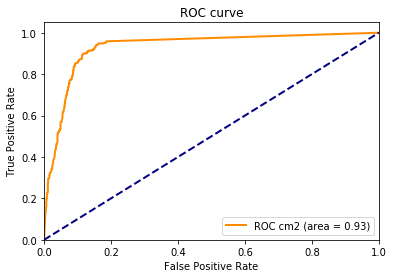

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc, roc_curve
        
        
 
class Model():
    '''
    This is the central class that will train my models
    '''
    def __init__(self, data_df, config):
        '''
        TODO: comment this whole class
        '''
        self.base_data = data_df
        self.config = config
                
        self._generate_data_splits(config['data'])
        self._build_model(config['model'])
        
        
        
    def _generate_data_splits(self, config):
        
        
        
        splits_config = config['splits']
        
        splits = {}
        
        for name, params in splits_config.items():
            
            data = self.base_data
            
            rows = (data['hour_slot'] >= params['start_hour']) & (data['hour_slot'] <= params['end_hour'])
            data = data[rows]
        
            if params['devices'] != 'all':
                rows = data['device'] in params['devices']
                data = data[rows]
                
        
            xy_config = config['xy']    
            y = data[xy_config['y_col']]
            X = data[xy_config['X_cols']]
            
            test_size = params['test_perc']
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
            
            data = Data(X_train, X_test, y_train, y_test)
            
            splits[name] = data
            
            self.data_splits = splits

            
        
    def _build_model(self, model_config):
        
        model = model_config['model_class']
        model = model(**model_config['paramaters'])
        
        data = self.data_splits[model_config['data_split']]
        
        data.X_train = pd.get_dummies(data.X_train)
        X_train = data.X_train
        data.X_test = pd.get_dummies(data.X_test)
        X_test = data.X_test
        
        y_train = data.y_train
        y_test = data.y_test
        
        model.fit(X_train, y_train)
        self.model = model
        
        
    def _plot_roc_curve(self, data_split = 'train', use_test=True):
        
        
        data = self.data_splits[data_split]
        X, y = (data.X_test, data.y_test) if use_test else (data.X_train, data.y_train)
        X = pd.get_dummies(X)
        predicted = self.model.predict_proba(X)[:,1]
            
        fpr, tpr, thresholds = roc_curve(y, predicted)
        roc_auc = auc(fpr, tpr)
        print('AUC: {}'.format(roc_auc))
        
        plt.figure()
        
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC cm2 (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()
        
        
        
            
model = Model(data_df = modeling_df, config=first_config)
model._plot_roc_curve(data_split = 'train', use_test=True)

In [ ]:
general_config = config['general']
xy_config = config['xy']

data = self.base_data
rows = (data['hour_slot'] >= general_config['start_hour']) & (data['hour_slot'] <= general_config['end_hour'])
data = data[rows]

if general_config['devices'] != 'all':
    rows = data['device'] in general_config['devices']
    data = data[rows]


y = data[xy_config['y_col']]
X = data[xy_config['X_cols']]

self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=general_config['test_perc'])

In [ ]:
enc = OneHotEncoder()
        X_train = enc.fit(X_train).transform(X_train)
        X_test = enc.transform(X_test)
        
        model.fit(X_train, y_train)
        predicted = model.predict_proba(X_test)[:,1]
        
        fpr, tpr, thresholds = roc_curve(y_test, predicted)
        roc_auc = auc(fpr, tpr)

0.18884408602150538